In [23]:
from monai.transforms import (
                            Compose,
                            OneOf,
                            
                            AsDiscreted,

                            LoadImaged,
                            EnsureTyped,
                            ScaleIntensityRanged,
                            
                            Orientationd,
                            CropForegroundd, 
                            RandCropByPosNegLabeld,
                            RandSpatialCropd,

                            ## nnUNet v1 impl Aug
                            RandFlipd,
                            RandRotated,
                            Rand3DElasticd,
                            RandScaleIntensityd,
                            RandAdjustContrastd, # gamma correction
                            
                            Resized,
                            Spacingd,
                            RandGaussianNoised,
                            RandGaussianSmoothd,
                            RandShiftIntensityd,

                            # RandAdjustContrastd,
                            # RandGaussianSharpend,

                            # RandCoarseDropoutd,
                            # RandCoarseShuffled
                        )

import torch

In [24]:
img = '/root/snsb/data/mri/DUIH_0123/T1.nii.gz'
seg = '/root/snsb/data/mri/DUIH_0123/aseg.nii.gz'

In [25]:
all_key = ['img','seg']

full_transform = Compose([LoadImaged(keys=all_key, image_only=True, ensure_channel_first=True),
         EnsureTyped(keys=all_key, device=None, track_meta=False),
        #  Orientationd(keys=all_key, axcodes="RAS"),
         CropForegroundd(keys=all_key, source_key='seg', allow_smaller=False, select_fn=lambda x: x>0),
         AsDiscreted(keys='seg', to_onehot=3),
        #  Resized(keys=all_key, spatial_size=(256,256,256)),
        #  ScaleIntensityRanged(keys='img',
        #                         a_max=255, a_min=0,
        #                         b_max=1, b_min=0, clip=True),
                ])

In [26]:
d = {'img':img, 'seg':seg}

In [27]:
loader = LoadImaged(keys=all_key, image_only=True, ensure_channel_first=True)

loaded = loader(d)

loaded['img'].shape, loaded['seg'].shape

(torch.Size([1, 256, 256, 256]), torch.Size([1, 256, 256, 256]))

In [28]:
ensure = EnsureTyped(keys=all_key, device=None, track_meta=False)

ensured = ensure(loaded)

ensured['img'].shape, torch.unique(ensured['img']), ensured['seg'].shape, torch.unique(ensured['seg'])

(torch.Size([1, 256, 256, 256]),
 tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
          24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
          36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
          60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
          72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
          84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
          96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
         108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
         120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
         132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 1

In [29]:
# onehot = AsDiscreted(keys='seg', to_onehot=3)

# onehoted = onehot(ensured)

# onehoted['img'].shape, onehoted['seg'].shape

In [30]:
# ori = Orientationd(keys=all_key, axcodes="RAS")

# orited = ori(ensured)

# orited['img'].shape, orited['seg'].shape, orited['img']

In [31]:
cropper = CropForegroundd(keys=all_key, source_key='seg', allow_smaller=False, select_fn=lambda x: x>0)

cropped = cropper(ensured)

cropped['img'].shape, cropped['seg'].shape
# 128 128 192

(torch.Size([1, 132, 118, 169]), torch.Size([1, 132, 118, 169]))

In [35]:
onehot = AsDiscreted(keys='seg', to_onehot=3)

onehoted = onehot(cropped)

onehoted['img'].shape, onehoted['seg'].shape

(torch.Size([1, 132, 118, 169]), torch.Size([3, 132, 118, 169]))

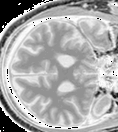

In [36]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import PIL

tensor2PTL = T.ToPILImage()
img = tensor2PTL(onehoted['img'][..., 128])
seg = tensor2PTL(onehoted['seg'][..., 128])

img.show()

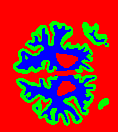

In [37]:
seg.show()

In [23]:
resizer = Resized(keys=all_key, spatial_size=(128,128,160))

resized = resizer(onehoted)

resized['img'].shape, resized['seg'].shape

(torch.Size([1, 128, 128, 160]), torch.Size([3, 128, 128, 160]))

In [24]:
norm = ScaleIntensityRanged(keys='img',
                                a_max=255, a_min=0,
                                b_max=1, b_min=0, clip=True)

print(torch.unique(resized['img']))

normed = norm(onehoted)

normed['img'].shape, normed['seg'].shape

# print(torch.unique(normed['img']))

metatensor([  0.0000,   0.5000,   0.6250,  ..., 236.5000, 236.7500, 240.5000])


(torch.Size([1, 135, 108, 147]), torch.Size([3, 135, 108, 147]))

In [39]:
import glob


li = glob.glob('/root/snsb/data/mri/*')
li

avg_H = 0.
avg_W = 0.
avg_D = 0.
for path in li:
    path_d = {
            'img': f'{path}/T1.nii.gz',
            'seg': f'{path}/aseg.nii.gz'
        }
    
    try:
        d = full_transform(path_d)
    except Exception as ex:
        print(path_d)
        
    
    print(path, d['img'].shape, d['seg'].shape)
    C, H, W, D = d['seg'].shape
    
    avg_H += H
    avg_W += W
    avg_D += D
    

deno = len(li)

avg_H /= deno
avg_W /= deno
avg_D /= deno

print(avg_H, avg_W, avg_H, avg_D)
    
# full_transform



/root/snsb/data/mri/DUIH_0051 torch.Size([1, 135, 113, 157]) torch.Size([3, 135, 113, 157])
/root/snsb/data/mri/DUIH_0063 torch.Size([1, 127, 106, 152]) torch.Size([3, 127, 106, 152])
/root/snsb/data/mri/DUIH_0040 torch.Size([1, 147, 121, 166]) torch.Size([3, 147, 121, 166])
/root/snsb/data/mri/DUIH_0087 torch.Size([1, 130, 110, 164]) torch.Size([3, 130, 110, 164])
/root/snsb/data/mri/DUIH_0115 torch.Size([1, 133, 105, 151]) torch.Size([3, 133, 105, 151])
/root/snsb/data/mri/DUIH_0035 torch.Size([1, 126, 109, 150]) torch.Size([3, 126, 109, 150])
/root/snsb/data/mri/DUIH_0092 torch.Size([1, 133, 109, 154]) torch.Size([3, 133, 109, 154])
/root/snsb/data/mri/DUIH_0083 torch.Size([1, 128, 112, 149]) torch.Size([3, 128, 112, 149])
/root/snsb/data/mri/DUIH_0052 torch.Size([1, 128, 108, 160]) torch.Size([3, 128, 108, 160])
/root/snsb/data/mri/DUIH_0073 torch.Size([1, 131, 108, 151]) torch.Size([3, 131, 108, 151])
/root/snsb/data/mri/DUIH_0026 torch.Size([1, 134, 106, 147]) torch.Size([3, 134,

112